By Sarah Auch

Epoch [10/100]
Traditional Loss: 0.4002
HHH Loss: 0.2914

Epoch [20/100]
Traditional Loss: 0.3280
HHH Loss: 0.2169

Epoch [30/100]
Traditional Loss: 0.3294
HHH Loss: 0.1651

Epoch [40/100]
Traditional Loss: 0.3614
HHH Loss: 0.1495

Epoch [50/100]
Traditional Loss: 0.3893
HHH Loss: 0.1467

Epoch [60/100]
Traditional Loss: 0.3004
HHH Loss: 0.1278

Epoch [70/100]
Traditional Loss: 0.3348
HHH Loss: 0.1058

Epoch [80/100]
Traditional Loss: 0.3717
HHH Loss: 0.1328

Epoch [90/100]
Traditional Loss: 0.3601
HHH Loss: 0.1064

Epoch [100/100]
Traditional Loss: 0.3066
HHH Loss: 0.1044



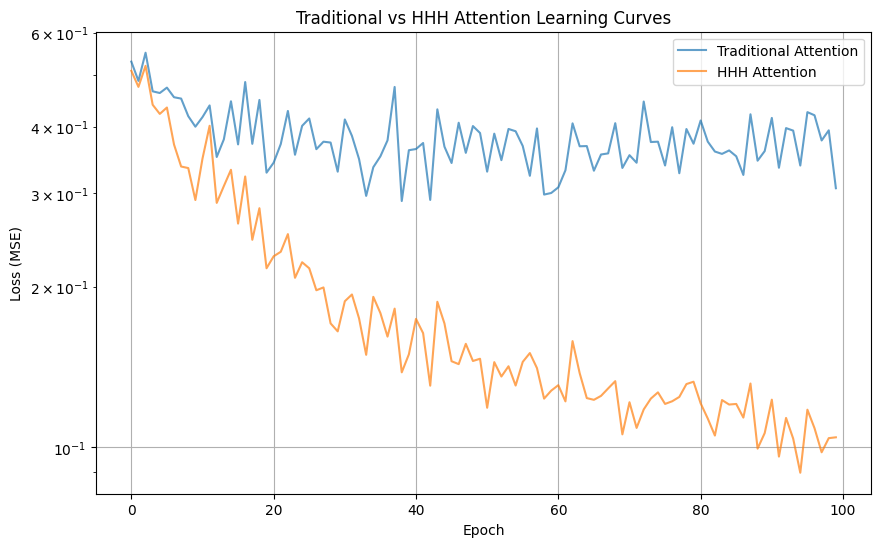


Traditional Attention Predictions:


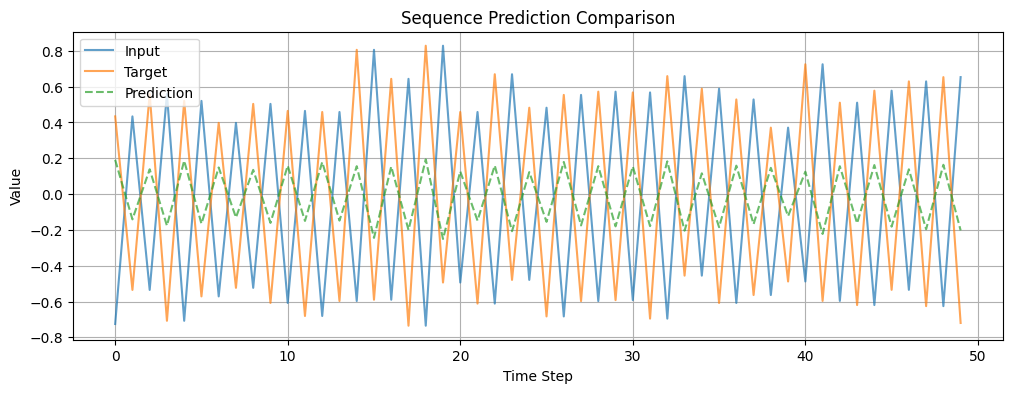


HHH Attention Predictions:


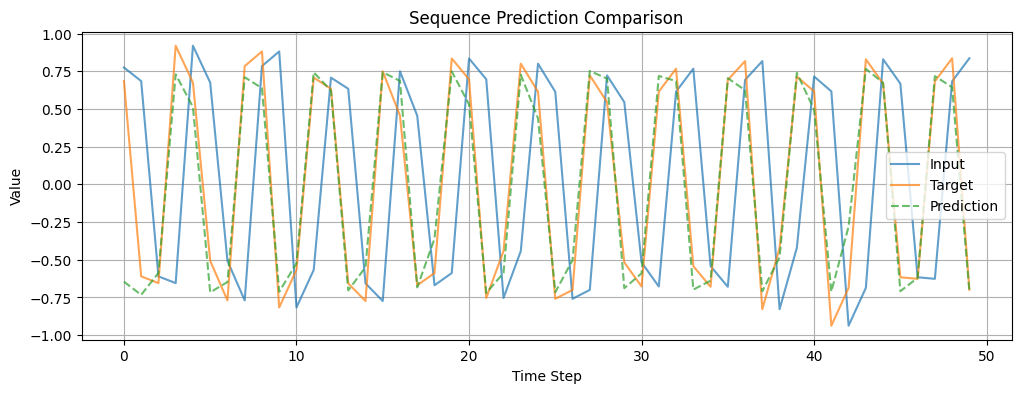

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import matplotlib.pyplot as plt
import numpy as np

class TransformerAttention(nn.Module):
    def __init__(self, hidden_size=64, num_heads=4):
        super().__init__()
        assert hidden_size % num_heads == 0, "hidden_size must be divisible by num_heads"
        
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads
        
        self.q_proj = nn.Linear(hidden_size, hidden_size)
        self.k_proj = nn.Linear(hidden_size, hidden_size)
        self.v_proj = nn.Linear(hidden_size, hidden_size)
        self.out_proj = nn.Linear(hidden_size, hidden_size)
        
    def forward(self, x, mask=None):
        B, L, H = x.shape
        
        # Project and reshape
        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)
        
        # Reshape to (batch, num_heads, seq_len, head_dim)
        q = q.view(B, L, self.num_heads, self.head_dim).transpose(1, 2)
        k = k.view(B, L, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.view(B, L, self.num_heads, self.head_dim).transpose(1, 2)

        # Compute attention scores
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        attn_probs = torch.softmax(scores, dim=-1)
        out = torch.matmul(attn_probs, v)
        
        # Reshape back to (batch, seq_len, hidden_size)
        out = out.transpose(1, 2).contiguous().view(B, L, H)
        return self.out_proj(out)

class HHHAttention(nn.Module):
    def __init__(self, hidden_size=64, num_heads=4, state_size=32):
        super().__init__()
        assert hidden_size % num_heads == 0, "hidden_size must be divisible by num_heads"
        
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads
        self.state_size = state_size
        
        self.q_proj = nn.Linear(hidden_size, hidden_size)
        self.k_proj = nn.Linear(hidden_size, hidden_size)
        self.v_proj = nn.Linear(hidden_size, hidden_size)
        self.out_proj = nn.Linear(hidden_size, hidden_size)
        
        self.state_update = nn.ModuleDict({
            'input_gate': nn.Linear(hidden_size + state_size, state_size),
            'forget_gate': nn.Linear(hidden_size + state_size, state_size),
            'update_gate': nn.Linear(hidden_size + state_size, state_size)
        })
        self.state_proj = nn.Linear(state_size, self.head_dim)
        
    def update_state(self, state, input_token):
        B = input_token.size(0)
        
        # Reshape input_token to (B * num_heads, hidden_size)
        if input_token.dim() == 3:  # (B, 1, H)
            input_token = input_token.squeeze(1)  # (B, H)
        input_token = input_token.unsqueeze(1).expand(-1, self.num_heads, -1)  # (B, num_heads, H)
        input_token = input_token.reshape(B * self.num_heads, -1)  # (B * num_heads, H)
        
        # Reshape state to (B * num_heads, state_size)
        state_2d = state.reshape(B * self.num_heads, -1)  # (B * num_heads, state_size)
        
        # Concatenate along feature dimension
        combined = torch.cat([state_2d, input_token], dim=-1)
        
        # Apply gates
        i = torch.sigmoid(self.state_update['input_gate'](combined))
        f = torch.sigmoid(self.state_update['forget_gate'](combined))
        u = torch.tanh(self.state_update['update_gate'](combined))
        
        # Update state
        new_state = f * state_2d + i * u
        
        # Reshape back to (B, num_heads, state_size)
        return new_state.view(B, self.num_heads, self.state_size)
    
    def forward(self, x, mask=None):
        B, L, H = x.shape
        state = torch.zeros(B, self.num_heads, self.state_size, device=x.device)
        outputs = []
        
        # Process each time step
        for t in range(L):
            # Update state with current input
            curr_input = x[:, t, :]  # (B, H)
            state = self.update_state(state, curr_input)
            
            # Project current sequence to Q, K, V
            q = self.q_proj(x).view(B, L, self.num_heads, self.head_dim).transpose(1, 2)
            k = self.k_proj(x).view(B, L, self.num_heads, self.head_dim).transpose(1, 2)
            v = self.v_proj(x).view(B, L, self.num_heads, self.head_dim).transpose(1, 2)
            
            # Project state and add to attention scores
            state_contribution = self.state_proj(state).unsqueeze(2)  # (B, num_heads, 1, head_dim)
            
            # Compute attention scores
            scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
            state_scores = torch.matmul(state_contribution, k.transpose(-2, -1))
            scores = scores + state_scores
            
            if mask is not None:
                scores = scores.masked_fill(mask == 0, -1e9)
            
            # Apply attention
            attn_probs = torch.softmax(scores, dim=-1)
            out = torch.matmul(attn_probs, v)
            
            # Reshape and project output
            out = out.transpose(1, 2).contiguous().view(B, L, H)
            outputs.append(out[:, t:t+1, :])
        
        # Combine all outputs
        out_seq = torch.cat(outputs, dim=1)
        return self.out_proj(out_seq)

def plot_comparison(trad_losses, hhh_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(trad_losses, label='Traditional Attention', alpha=0.7)
    plt.plot(hhh_losses, label='HHH Attention', alpha=0.7)
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Traditional vs HHH Attention Learning Curves')
    plt.legend()
    plt.yscale('log')
    plt.grid(True)
    plt.show()

def visualize_predictions(model, seq_length=50):
    x, y = generate_sequence_data(batch_size=1, seq_length=seq_length)
    
    with torch.no_grad():
        pred = model(x)
    
    plt.figure(figsize=(12, 4))
    plt.plot(x[0, :, 0].numpy(), label='Input', alpha=0.7)
    plt.plot(y[0, :, 0].numpy(), label='Target', alpha=0.7)
    plt.plot(pred[0, :, 0].numpy(), label='Prediction', alpha=0.7, linestyle='--')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.title('Sequence Prediction Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    # Train models and plot results
    trad_losses, hhh_losses, trad_model, hhh_model = train_and_compare(
        num_epochs=100,
        batch_size=32,
        seq_length=20
    )
    
    # Plot learning curves
    plot_comparison(trad_losses, hhh_losses)
    
    # Visualize predictions
    print("\nTraditional Attention Predictions:")
    visualize_predictions(trad_model)
    
    print("\nHHH Attention Predictions:")
    visualize_predictions(hhh_model)


In [28]:
class OptimizedHHHAttention(nn.Module):
    def __init__(self, hidden_size=64, num_heads=4, state_size=32):
        super().__init__()
        assert hidden_size % num_heads == 0, "hidden_size must be divisible by num_heads"
        
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads
        self.state_size = state_size
        
        # Combined projections for Q, K, V to reduce memory allocations
        self.qkv_proj = nn.Linear(hidden_size, 3 * hidden_size)
        self.out_proj = nn.Linear(hidden_size, hidden_size)
        
        # Optimized state update mechanism
        self.state_update = nn.Linear(hidden_size + state_size, 3 * state_size)
        self.state_proj = nn.Linear(state_size, self.head_dim)
        
        # Layer normalization for stability
        self.norm = nn.LayerNorm(hidden_size)
        
    def update_state_batch(self, state, input_seq):
        """
        Batch update state for all time steps at once
        """
        B, L, H = input_seq.shape
        state = state.unsqueeze(1).expand(-1, L, -1, -1)  # [B, L, num_heads, state_size]
        
        # Prepare input for state update
        input_expanded = input_seq.unsqueeze(2).expand(-1, -1, self.num_heads, -1)
        combined = torch.cat([state, input_expanded], dim=-1)
        
        # Get all gates at once
        gates = self.state_update(combined.view(-1, self.hidden_size + self.state_size))
        i, f, u = gates.chunk(3, dim=-1)
        
        # Apply gates with vectorized operations
        i, f = torch.sigmoid(i), torch.sigmoid(f)
        u = torch.tanh(u)
        
        # Update state for all steps at once
        new_states = (f * state.view(-1, self.state_size) + 
                     i * u).view(B, L, self.num_heads, self.state_size)
        
        return new_states
    
    def forward(self, x, mask=None):
        B, L, H = x.shape
        
        # Apply layer norm first
        x = self.norm(x)
        
        # Get initial state
        state = torch.zeros(B, self.num_heads, self.state_size, device=x.device)
        
        # Project input to Q, K, V at once
        qkv = self.qkv_proj(x)
        q, k, v = qkv.chunk(3, dim=-1)
        
        # Reshape Q, K, V
        q = q.view(B, L, self.num_heads, self.head_dim).transpose(1, 2)
        k = k.view(B, L, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.view(B, L, self.num_heads, self.head_dim).transpose(1, 2)
        
        # Update states for all time steps at once
        states = self.update_state_batch(state, x)
        
        # Project states to attention space
        state_contrib = self.state_proj(states)  # [B, L, num_heads, head_dim]
        state_contrib = state_contrib.transpose(1, 2)  # [B, num_heads, L, head_dim]
        
        # Compute attention scores with state contribution
        scale = math.sqrt(self.head_dim)
        scores = torch.matmul(q + state_contrib, k.transpose(-2, -1)) / scale
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        # Apply attention
        attn_probs = torch.softmax(scores, dim=-1)
        out = torch.matmul(attn_probs, v)
        
        # Reshape and project output
        out = out.transpose(1, 2).contiguous().view(B, L, H)
        return self.out_proj(out)

# Helper function to compare compute usage
def compare_compute_efficiency(traditional_model, hhh_model, seq_length=50, n_samples=100):
    traditional_times = []
    hhh_times = []
    
    x, _ = generate_sequence_data(batch_size=1, seq_length=seq_length)
    
    # Warmup
    for _ in range(5):
        with torch.no_grad():
            traditional_model(x)
            hhh_model(x)
    
    # Measure inference times
    for _ in range(n_samples):
        # Traditional
        start = time.time()
        with torch.no_grad():
            traditional_model(x)
        traditional_times.append(time.time() - start)
        
        # HHH
        start = time.time()
        with torch.no_grad():
            hhh_model(x)
        hhh_times.append(time.time() - start)
    
    return {
        'traditional_avg': np.mean(traditional_times) * 1000,  # ms
        'hhh_avg': np.mean(hhh_times) * 1000,  # ms
        'traditional_std': np.std(traditional_times) * 1000,  # ms
        'hhh_std': np.std(hhh_times) * 1000  # ms
    }

Epoch [10/100]
Traditional Loss: 0.4624
HHH Loss: 0.3952

Epoch [20/100]
Traditional Loss: 0.4258
HHH Loss: 0.3013

Epoch [30/100]
Traditional Loss: 0.3948
HHH Loss: 0.1951

Epoch [40/100]
Traditional Loss: 0.3236
HHH Loss: 0.1525

Epoch [50/100]
Traditional Loss: 0.3881
HHH Loss: 0.1520

Epoch [60/100]
Traditional Loss: 0.3894
HHH Loss: 0.1303

Epoch [70/100]
Traditional Loss: 0.4019
HHH Loss: 0.1291

Epoch [80/100]
Traditional Loss: 0.3356
HHH Loss: 0.1274

Epoch [90/100]
Traditional Loss: 0.3332
HHH Loss: 0.1046

Epoch [100/100]
Traditional Loss: 0.3430
HHH Loss: 0.1071

Measuring compute metrics...


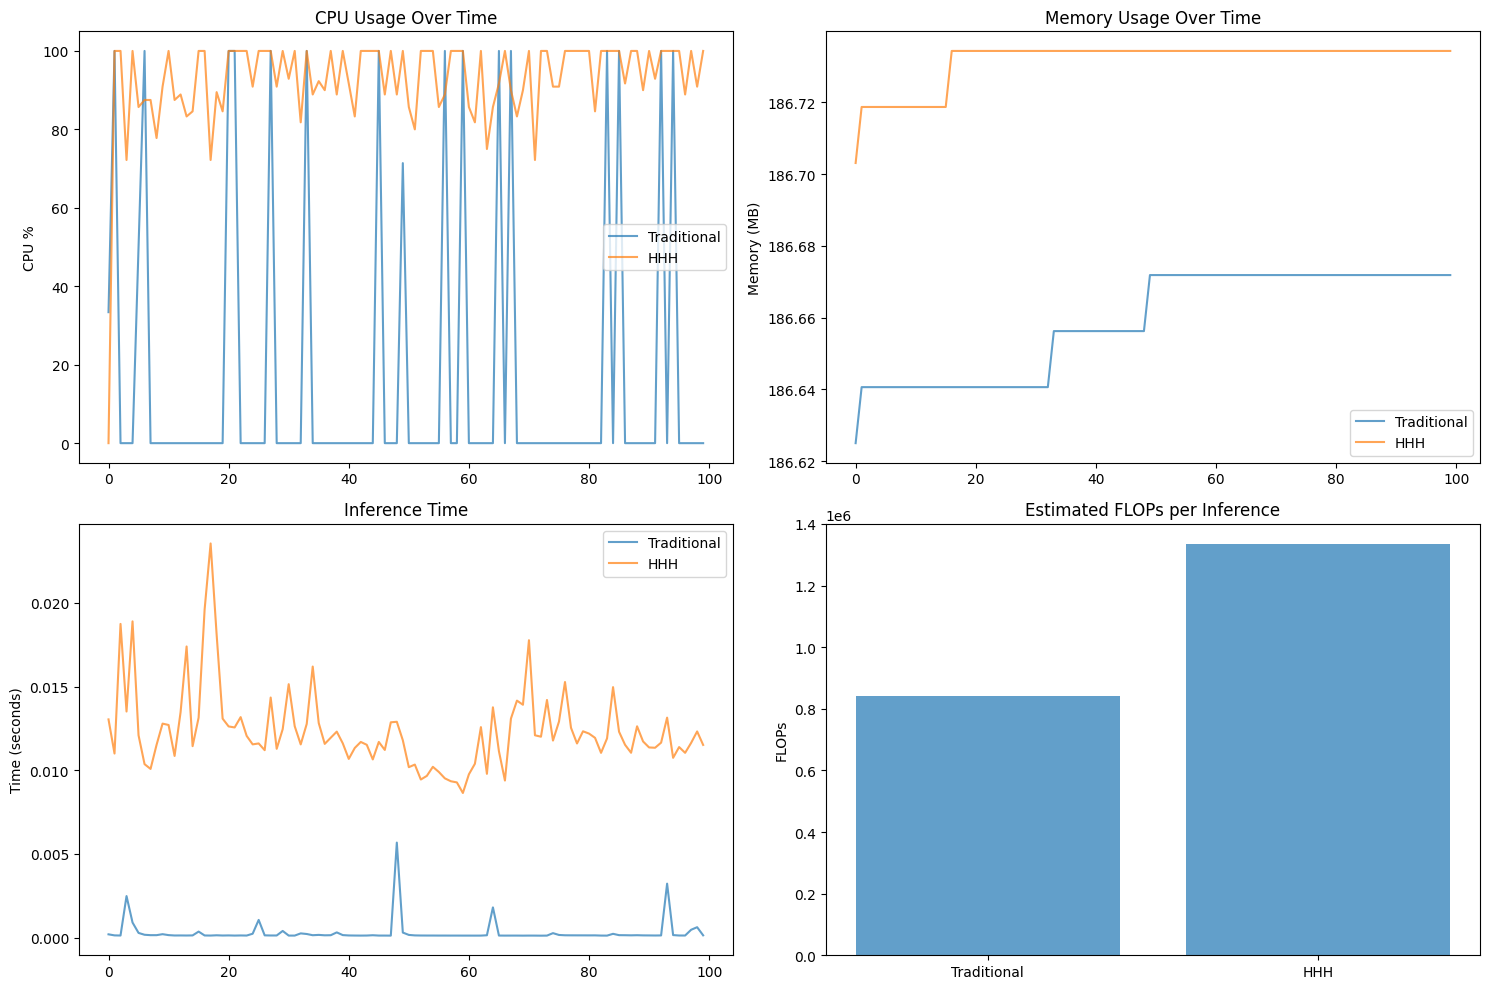


Traditional Attention Profiling:
------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                    Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
         model_inference        25.90%     219.874us       100.00%     848.958us     848.958us         200 b    -204.69 Kb             1  
           aten::softmax         1.30%      11.001us        40.51%     343.917us     343.917us      39.06 Kb           0 b             1  
          aten::_softmax        39.21%     332.916us        39.21%     332.916us     332.916us      39.06 Kb      39.06 Kb             1  
            aten::linear         2.87%      24.371us        15.03%     127.583us      21.264us      62.70 Kb           0 b          

In [27]:
import torch
import time
import psutil
import numpy as np
import matplotlib.pyplot as plt
from torch.profiler import profile, record_function, ProfilerActivity

# First create both models
traditional_model = SequencePredictor('traditional', hidden_size=64, num_heads=4)
hhh_model = SequencePredictor('hhh', hidden_size=64, num_heads=4, state_size=32)

# Train the models
trad_losses, hhh_losses, traditional_model, hhh_model = train_and_compare(
    num_epochs=100,
    batch_size=32,
    seq_length=20
)

def measure_compute_metrics(model, seq_length=50, n_iterations=100):
    cpu_usage = []
    memory_usage = []
    inference_times = []
    flops_estimates = []
    
    # Get initial memory allocation
    initial_memory = torch.cuda.memory_allocated() if torch.cuda.is_available() else 0
    
    for _ in range(n_iterations):
        # Generate new sequence
        x, y = generate_sequence_data(batch_size=1, seq_length=seq_length)
        
        # Record CPU usage
        cpu_usage.append(psutil.cpu_percent())
        
        # Record memory usage
        memory_usage.append(psutil.Process().memory_info().rss / 1024 / 1024)  # MB
        
        # Time the inference
        start_time = time.time()
        with torch.no_grad():
            pred = model(x)
        inference_times.append(time.time() - start_time)
        
        # Estimate FLOPs (rough approximation)
        num_params = sum(p.numel() for p in model.parameters())
        flops_estimates.append(num_params * seq_length)
    
    return {
        'cpu_usage': cpu_usage,
        'memory_usage': memory_usage,
        'inference_times': inference_times,
        'flops_estimates': flops_estimates
    }

def plot_compute_metrics(trad_metrics, hhh_metrics):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # CPU Usage
    ax1.plot(trad_metrics['cpu_usage'], label='Traditional', alpha=0.7)
    ax1.plot(hhh_metrics['cpu_usage'], label='HHH', alpha=0.7)
    ax1.set_title('CPU Usage Over Time')
    ax1.set_ylabel('CPU %')
    ax1.legend()
    
    # Memory Usage
    ax2.plot(trad_metrics['memory_usage'], label='Traditional', alpha=0.7)
    ax2.plot(hhh_metrics['memory_usage'], label='HHH', alpha=0.7)
    ax2.set_title('Memory Usage Over Time')
    ax2.set_ylabel('Memory (MB)')
    ax2.legend()
    
    # Inference Time
    ax3.plot(trad_metrics['inference_times'], label='Traditional', alpha=0.7)
    ax3.plot(hhh_metrics['inference_times'], label='HHH', alpha=0.7)
    ax3.set_title('Inference Time')
    ax3.set_ylabel('Time (seconds)')
    ax3.legend()
    
    # FLOPs Estimation
    ax4.bar(['Traditional', 'HHH'], 
            [np.mean(trad_metrics['flops_estimates']), 
             np.mean(hhh_metrics['flops_estimates'])],
            alpha=0.7)
    ax4.set_title('Estimated FLOPs per Inference')
    ax4.set_ylabel('FLOPs')
    
    plt.tight_layout()
    plt.show()

# Detailed profiling for one forward pass
def profile_model(model, seq_length=50):
    x, _ = generate_sequence_data(batch_size=1, seq_length=seq_length)
    
    with profile(activities=[ProfilerActivity.CPU],
                profile_memory=True, record_shapes=True) as prof:
        with record_function("model_inference"):
            with torch.no_grad():
                _ = model(x)
    
    print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

# Now measure and plot
print("Measuring compute metrics...")
trad_metrics = measure_compute_metrics(traditional_model)
hhh_metrics = measure_compute_metrics(hhh_model)
plot_compute_metrics(trad_metrics, hhh_metrics)

# Detailed profiling
print("\nTraditional Attention Profiling:")
profile_model(traditional_model)
print("\nHHH Attention Profiling:")
profile_model(hhh_model)